In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns  
import tqdm
import requests
from io import StringIO 
import geopandas as gpd

### Getting Location data

In [ ]:
import geonamescache
from geopy.geocoders import Nominatim

atlus_countries = pd.read_csv("data/Subtype-data/ATS-subtype5-con-reg.csv").Country.replace({"Czech Republic":"Czechia","Korea, South":"South Korea" }).unique()
gea_countries = pd.read_csv("data/Subtype-data/GEA-subtype5-con-reg.csv").Country.replace({"Czech Republic":"Czechia","Korea, South":"South Korea" }).unique()
countries= set(atlus_countries) | set(gea_countries)

def get_capital_city(country):
    gc = geonamescache.GeonamesCache()
    country_info = gc.get_countries_by_names()
    
    if country in country_info:
        country_data = country_info[country]
        if 'capital' in country_data:
            return country_data['capital']
    
    return None

def get_capital_coordinates(country):
    geolocator = Nominatim(user_agent="capital_locator")

    location = geolocator.geocode({"country":country, "city":get_capital_city(country)})
    if location:
        capital_latitude = location.latitude
        capital_longitude = location.longitude
        return capital_latitude, capital_longitude

country_location= {}

for country in tqdm.tqdm(countries):
    country_location[country]= get_capital_coordinates(country)

#Mannualy adding data for Hong Kong
country_location["Hong Kong"]=(22.293291, 114.161133)


### Fetching Environmental Variables using NASA POWER API

In [ ]:
parameters=["T2M", "QV2M", "RH2M", "T2M_MAX", "T2M_MIN"]

dfs=[]

def get_country_data(country):

    latitude, longitude= country_location[country]

    base_url = r"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M,QV2M,RH2M,T2M_MAX,T2M_MIN,PRECTOTCORR&community=RE&longitude={longitude}&latitude={latitude}&start=20140101&end=20220305&format=CSV"

    api_request_url = base_url.format(longitude=longitude, latitude=latitude)

    response = requests.get(url=api_request_url, verify=True, timeout=30.00)

    content = response.content.decode('utf-8')

    country_data=pd.read_csv(StringIO(content), skiprows=14)

    return country_data

def get_countries_data(countries):
    dfs=[]

    for country in tqdm.tqdm(countries):
        df= get_country_data(country)
        df["country"]=country
        dfs.append(df)

    return pd.concat(dfs)

env_data=get_countries_data(countries)
env_data.to_csv("data/env-data/env_data.csv", index=False)



### Calculating aggregates for Environmental Variables


In [2]:
env_data=pd.read_csv("data/env-data/env_data.csv")

yearly_data=env_data[env_data.YEAR.isin(range(2018,2022))].rename(columns={"country":"Country"})
yearly_data=yearly_data.groupby(["Country","YEAR"]).agg({"T2M":"mean","QV2M":"mean", "RH2M":"mean", "T2M_MAX":"max","T2M_MIN":"mean","PRECTOTCORR":"sum" })

yearly_data=yearly_data.reset_index()
yearly_data["Country"]=yearly_data.Country.replace({"Czechia":"Czech Republic", "Korea, South":"South Korea"})
yearly_data=yearly_data.rename(columns={"country":"Country"})
yearly_data

,Country,YEAR,T2M,QV2M,RH2M,T2M_MAX,T2M_MIN,PRECTOTCORR
0,Argentina,2018,18.316137,10.105863,75.757616,33.70,15.802164,1309.13
1,Argentina,2019,18.201671,10.086192,75.612137,31.80,15.603178,1077.96
2,Argentina,2020,18.112541,9.634727,73.008443,32.75,15.349180,757.13
3,Argentina,2021,18.250192,9.835973,74.477425,33.77,15.498000,863.02
4,Australia,2018,13.158685,6.453068,65.756247,38.03,7.459726,477.30
...,...,...,...,...,...,...,...,...
247,United States,2021,13.932630,8.442000,76.050027,36.50,9.140438,973.85
248,Venezuela,2018,23.242904,15.699808,84.146329,30.73,20.896575,1103.74
249,Venezuela,2019,24.338959,15.516027,78.635671,33.27,21.423315,453.47
250,Venezuela,2020,24.891721,15.366803,75.554563,33.76,21.885628,294.87


### Loading Subtype Prevalence Data

In [3]:
gea=pd.read_csv("data/Subtype-data/GEA-subtype5-con-reg.csv")

data= gea

data=data.groupby(["Year",	"Country",	"subtype"]).agg("sum").reset_index()
data=pd.pivot(data, columns="subtype", values="subtype.1",index=["Year","Country"])

#Normalizing data (# Subtype Samples / Total Samples (Country, Year))
data=data.div(data.sum(axis=1), axis=0)


data=data.fillna(0)

#Merging subtype prevalance data with env data
data=data.reset_index().merge(yearly_data, left_on=("Country", "Year"), right_on=("Country",'YEAR'))


### Regression Analysis

In [4]:
import pandas as pd
import statsmodels.api as sm

transformation_map={'T2M':None,	'QV2M':"log",	'RH2M':"log",	'T2M_MAX':None,	'T2M_MIN':None, 'PRECTOTCORR':"log"}



def perform_regression(df, x, year):
    # Create an empty dictionary to store the results
    regression_results = {}

    # Iterate through each column in the dataframe
    for column in df.loc[:, :"SSSSS"].columns:
        # Define the target column and predictor variable
        y = df[column]
        if transformation_map[x]:
            df[x] = np.log10(df[x]+1)

        #df[x]=(df[x] - df[x].mean())/df.std()

        X = df[x]#.drop(columns=column)

        
        # Add a constant term to the predictor variable (for the intercept)
        X = sm.add_constant(X)

        # Perform linear regression
        model = sm.OLS(y, X).fit()
        

        # Extract the results
        coefficient = model.params[1]  # Coefficient of the predictor variable
        p_value = model.pvalues[1]     # P-value of the predictor variable
        r_squared = model.rsquared     # R-squared value of the model
        error = model.mse_resid        # Mean squared error of the model

        # Store the results in the dictionary
        regression_results[column] = {
            'Coefficient': coefficient,
            'P-value': p_value,
            'R-squared': r_squared,
            'Error': error
        }

    df=pd.DataFrame(regression_results).T
    df['year']=year
    df["regressor"]=x

    return df.reset_index()

# # Usage example:
# # Assuming 'df' is your DataFrame, call the function and store the results
# results = perform_regression(atlus.loc[2018], 'PRECTOTCORR', year)

dfs=[]
for year in data.reset_index().Year.unique():
    for env_var in ['T2M',	'QV2M',	'RH2M',	'T2M_MAX',	'T2M_MIN', 'PRECTOTCORR']:#,
        df=perform_regression(data.set_index(["Year", "Country"]).loc[year], env_var, year)
        dfs.append(df)

/Users/raguln/anaconda3/envs/amr/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/raguln/anaconda3/envs/amr/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/raguln/anaconda3/envs/amr/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/raguln/anaconda3/envs/amr/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/raguln/anaconda3/envs/amr/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1

In [5]:
results=pd.concat(dfs)
results=results.set_index(["year", "index","regressor"])
results.to_csv("data/results/regression_results_gea.csv")

/Users/raguln/anaconda3/envs/amr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


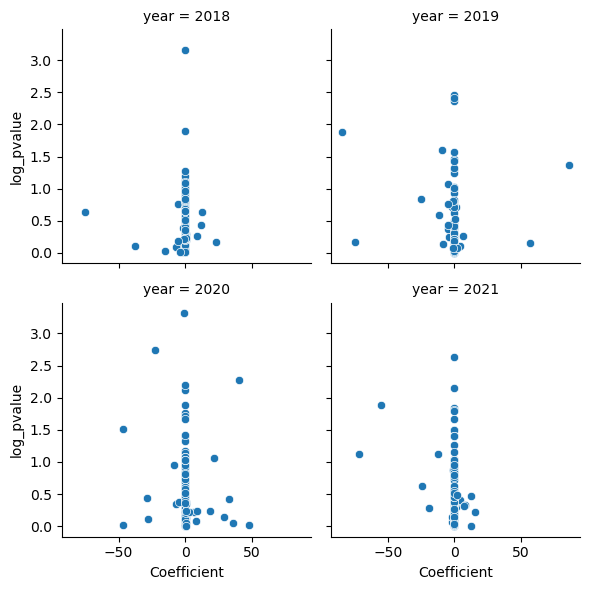

In [6]:
results=results.reset_index()
results["log_pvalue"]=-1 * np.log10(results["P-value"])

grid=sns.FacetGrid(data=results[results.Coefficient.abs()<100], col="year", col_wrap=2) #[~ results.log_pvalue.isna()]
grid.map_dataframe(sns.scatterplot,y="log_pvalue",x="Coefficient")


In [7]:
world= gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world=world.rename(columns={'name':'Country'})
world["Country"]=world.Country.replace({"United States of America":"United States"})

nasa_var_map={'RH2M':"Relative Humidity", 'PRECTOTCORR':"Precipitation", 'T2M':"Avg. Temprature", 
    'T2M_MIN':"Minimum Temprature", 'T2M_MAX':"Maximum Temprature" , 'QV2M':"Specific Humidity"}

/var/folders/q_/zps8bjts5z7flqlc29htypv00000gn/T/ipykernel_93026/2531407218.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world= gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


/Users/raguln/anaconda3/envs/amr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


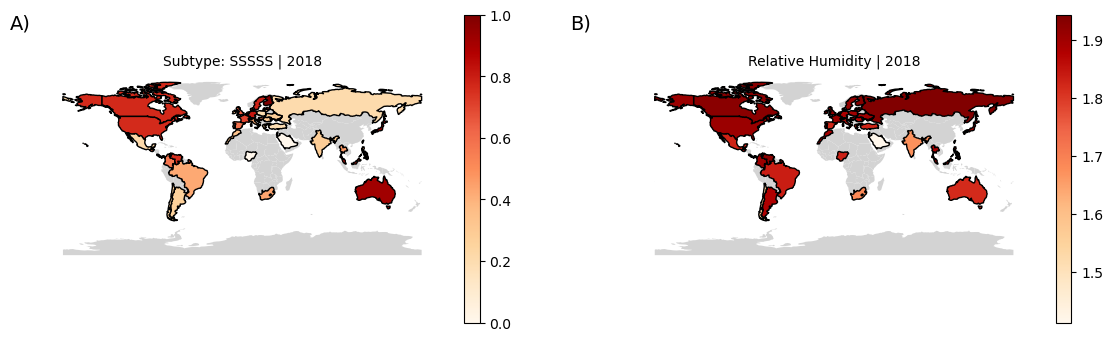

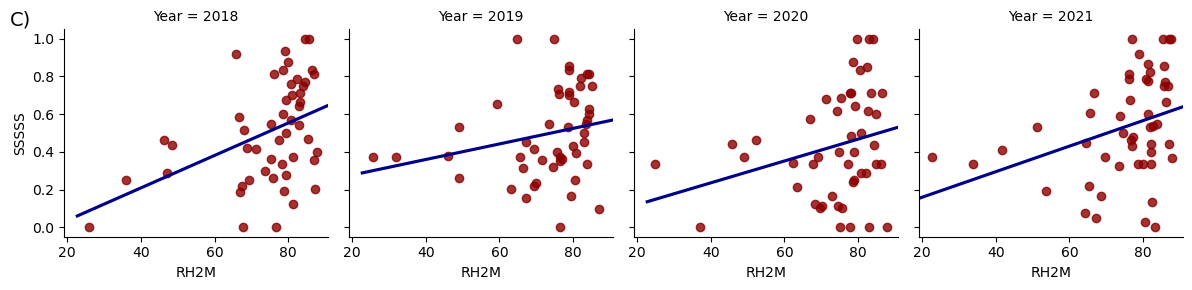

In [15]:
fig, (ax1, ax2)= plt.subplots(figsize=(14,8), ncols=2)

nasa_var_map={'RH2M':"Relative Humidity", 'PRECTOTCORR':"Precipitation", 'T2M':"Avg. Temprature", 
    'T2M_MIN':"Minimum Temprature", 'T2M_MAX':"Maximum Temprature" , 'QV2M':"Specific Humidity"}

world_data=world
reg_data=data.reset_index()
reg_data=reg_data[reg_data.Year==2018][["Year","Country","SSSSS", "RH2M"]]
reg_data["RH2M"]=np.log10(reg_data[ "RH2M"])

world_data= world_data.merge(reg_data, on="Country", how="left")#.fillna(0)

ax1=world[world_data["SSSSS"].isna()].plot(color='lightgrey', ax=ax1)
ax2=world[world_data["RH2M"].isna()].plot(color='lightgrey', ax=ax2)

ax1=world_data.plot(world_data["SSSSS"],legend=True,  edgecolor="black", cmap='OrRd',legend_kwds={'shrink': 0.5},ax=ax1)

ax2=world_data.plot(world_data["RH2M"], legend=True,  edgecolor="black", cmap='OrRd',legend_kwds={'shrink': 0.5}, ax=ax2)

ax1.axis("off")
ax2.axis("off")
# os.mkdir("figures")


ax1.set_title("Subtype: "+ "SSSSS"+ f" | {2018}", fontsize=10)


ax2.set_title( nasa_var_map["RH2M"]+ f" | {2018}",  fontsize=10)
fig.text(0.1, 0.67, "A)", fontdict={"fontsize":14})
fig.text(0.5, 0.67, "B)", fontdict={"fontsize":14})

plt.savefig("figures/supplementary-figure-3-ab-GEA.png", dpi=300, bbox_inches='tight')



grid=sns.FacetGrid(data=data.reset_index(), col="Year") #[~ results.log_pvalue.isna()]
grid.map_dataframe(sns.regplot,y="SSSSS",x="RH2M", ci=None, ax=ax2,truncate=False, robust=False,
                                 line_kws={"color":"darkblue", "linestyle":"-"},
                                scatter_kws={"color":"darkred"})
grid.fig.text(0.01, 0.9, "C)", fontdict={"fontsize":14})
plt.savefig("figures/supplementary-figure-3-c-GEA.png", dpi=300)

/Users/raguln/anaconda3/envs/amr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


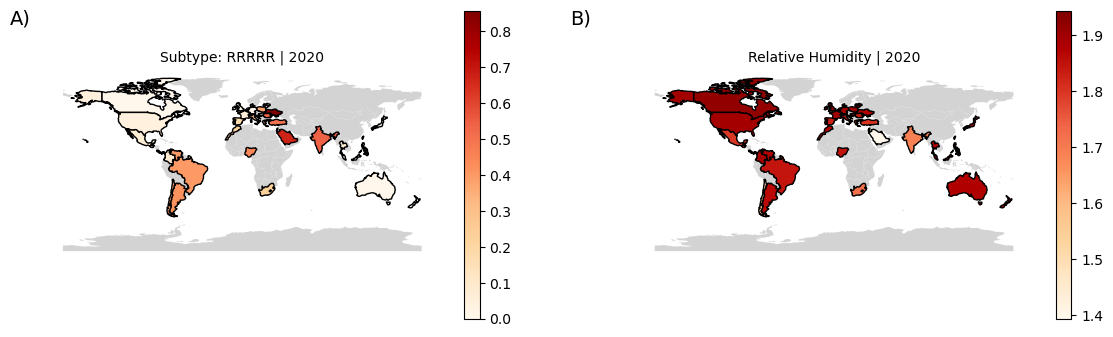

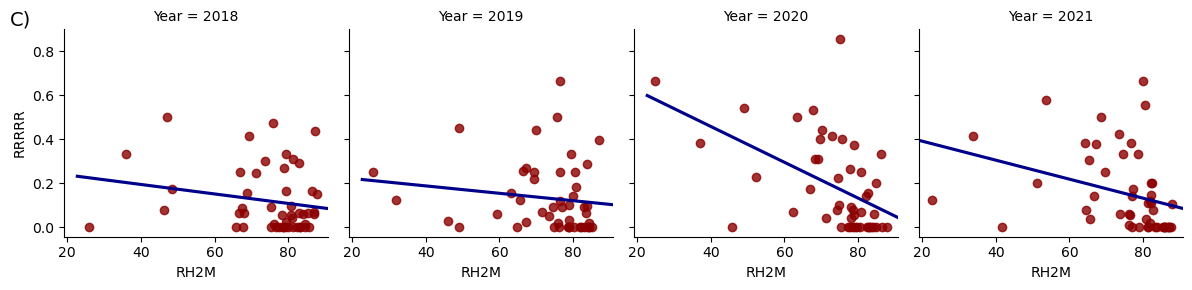

In [17]:
fig, (ax1, ax2)= plt.subplots(figsize=(14,8), ncols=2)


world_data=world
reg_data=data.reset_index()
reg_data=reg_data[reg_data.Year==2020][["Year","Country","RRRRR", "RH2M"]]
reg_data["RH2M"]=np.log10(reg_data[ "RH2M"])

world_data= world_data.merge(reg_data, on="Country", how="left")#.fillna(0)

ax1=world[world_data["RRRRR"].isna()].plot(color='lightgrey', ax=ax1)
ax2=world[world_data["RH2M"].isna()].plot(color='lightgrey', ax=ax2)

ax1=world_data.plot(world_data["RRRRR"],legend=True,  edgecolor="black", cmap='OrRd',legend_kwds={'shrink': 0.5},ax=ax1)

ax2=world_data.plot(world_data["RH2M"], legend=True,  edgecolor="black", cmap='OrRd',legend_kwds={'shrink': 0.5}, ax=ax2)

ax1.axis("off")
ax2.axis("off")



ax1.set_title("Subtype: "+ "RRRRR"+ f" | {2020}", fontsize=10)
ax2.set_title( nasa_var_map["RH2M"]+ f" | {2020}",  fontsize=10)
fig.text(0.1, 0.67, "A)", fontdict={"fontsize":14})
fig.text(0.5, 0.67, "B)", fontdict={"fontsize":14})

plt.savefig("figures/supplementary-figure-4-ab-GEA.png", dpi=300, bbox_inches='tight')



grid=sns.FacetGrid(data=data.reset_index(), col="Year") #[~ results.log_pvalue.isna()]
grid.map_dataframe(sns.regplot,y="RRRRR",x="RH2M", ci=None, ax=ax2,truncate=False, robust=False,
                                 line_kws={"color":"darkblue", "linestyle":"-"},
                                scatter_kws={"color":"darkred"})

grid.fig.text(0.01, 0.9, "C)", fontdict={"fontsize":14})
plt.savefig("figures/supplementary-figure-4-c-GEA.png", dpi=300)
